# Исследование поведения пользователей мобильного приложения

### Описане проекта

Цель исследования: проанализировать поведения пользователей в приложении и исследование влияния изменения шрифта.

Задачи: 
1. Проанализировать сценарий пользователей до момента покупки
2. Проанализировать на каких этапах пользователи останавливаются в воронке
3. Провести А/А-тест и сделать выводы
4. Провести A/B-тест и сделать выводы

###  Открытие файла с данными и изучение общей информации

Импортируем бибилиотеки, которые могут понадобится в ходе исследования

In [1]:
#Импорт библиотек
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
from datetime import datetime, timedelta, date
from scipy import stats as st
import math as mth

Прочтем данные и посмотрим из каких полей состоит таблица

In [2]:
#Запись таблицы
data = pd.read_csv('/datasets/logs_exp.csv',sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


В таблице содердится информация о названии ивента, ID девайса(также индефикатор пользователя), дата в формате "Timestamp" и номер A/A/B групп для проверки гипотез.

Заметим, что название столбцов - неудонбое. Форматом даты является "Timestamp", его можно преобразовать в дату-время и просто дату, а сам столбец "EventTimestamp" не нужен. 

### Подготовка данных

Для начала изменим название таблиц на более удобное

In [3]:
#Меняем название полей
data.columns = ['event','id','datetime','group']

In [4]:
#Обработка данных
data = data[data['event']!='Tutorial']

Теперь проверим, есть ли необходимость в обработке данных. Важно, чтобы в данных не было пропусков, чтобы не было дубликатов в стобце ивентов и кол-во групп в размере 3 штуки. Сначала проверим, есть пропуски

In [5]:
#Метод инфо
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243074 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   event     243074 non-null  object
 1   id        243074 non-null  int64 
 2   datetime  243074 non-null  int64 
 3   group     243074 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


Пропусков и нулевых значений нет. Тип данных совпадает с требуемым. Теперь посмотрим все уникальные значения названий ивентов. Предположим, что аналитики предоставили нам только те ивенты, которые нужны для формирования воронки, потому уникальных значений должно быть немного.

In [6]:
#Вывод уникальных значений event
print(data['event'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear']


Дубликатов нет. По предоставленным ивентам можно сформировать воронку: 'Tutorial' - 'MainScreenAppear' - 'OffersScreenAppear' - 'CartScreenAppear' - 'PaymentScreenSuccessful'. То есть сначала пользователь проходит туториал, далее попадает на главную страничку, после он выбирает какое-либо предложение, далее он переходит в корзину, где может перейти на страничку оплаты, где и происходит оплата. Туториал - начальное событие, которое можно пройти один раз. Далее он оказывает на главной странице, к которой он может возваращаться много раз. Чтобы попасть на страничку предложения нужно сначала попасть на главную страницу, потому это дейсвтие идет после. Возможность перейти в корзину "CartScreen" только после выбора предложения (конечно можно переходить в корзину и без покупок). И конечное дейсвтие - факт удачной оплаты.

Проверим кол-во уникальных значений group. 

In [7]:
#Поиск кол-ва дубликатов
data.duplicated().sum()

379

In [8]:
#Обраотка дубликатов
data = data[data.duplicated()==False]

In [9]:
#Вывод кол-ва уникальных значений group
print('Кол-во уникальных group:', len(data['group'].unique()))

Кол-во уникальных group: 3


Есть контрольная группа (246) и две сравниваемые группы (247 и 248). Теперь преобразуем Timestamp в дату-время и создадим столбец даты.

In [10]:
#Преобразование в дату-время
data['datetime'] = pd.to_datetime(data['datetime'], unit="s")

#Преобразование в дату
data['date'] = data['datetime'].dt.date

**Вывод: были заменены название столбцов и созданы поля даты и даты-время. Данные не требуют обработки.**

### Изучене и проверка данных

Посомтрим сколько всего событий в логе.

In [11]:
#Вывод кол-ва уникальных ивентов
print('Кол-во уникальных ивентов:', len(data['event'].unique()))

Кол-во уникальных ивентов: 4


Всего произошло уникальных ивентов 5, а всего ивентов было 244126. Выше я составил предполагаемую воронку: 'Tutorial' - 'MainScreenAppear' - 'OffersScreenAppear' - 'CartScreenAppear' - 'PaymentScreenSuccessful'.

Посмотрим сколько пользователей в логе. И сколько приходится ивентов на одного пользователя в среднем.

In [12]:
#Вывод кол-ва уникальных пользователей
print('Кол-во уникальных пользователей:', len(data['id'].unique()))
print('Ср кол-во ивентов на пользователя', len(data)/len(data['id'].unique()))

Кол-во уникальных пользователей: 7547
Ср кол-во ивентов на пользователя 32.15781105074864


На одного пользователя приходится целых 32 ивента. Это вполне возможно, если выбирал много товаров, тогда он постоянно заходил на главную стр и страницу предложения. Теперь посмотрим охват переиодов.

In [13]:
#Просмотр левой и правых границ дат в дата-сете
print('Левая граница:',data['date'].min())
print('Правая граница:',data['date'].max())

Левая граница: 2019-07-25
Правая граница: 2019-08-07


Охват около 2 неделель с 25 июля до 7 августа. Важно учитывать то, что данные должны иметь одинаковую плотность ивентов на протяжении всего наблюдения. 

Построим гистограмму по дате и времени.

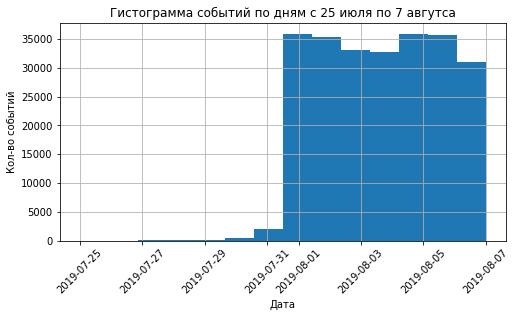

In [14]:
#Построение формы графика
plt.figure(figsize=(8, 4))
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Гистограмма событий по дням с 25 июля по 7 авгутса')
plt.xticks(rotation=45) 

#Построение гистограммы
data['date'].hist(bins=14)

plt.show()

Видим, что основное кол-во ивентов идет с 1 августа и резкий разрыв после 31 июля. Иначе говоря, будет некорректно сравнивать например срезы 31.07 и 01.08 и срезы после, так как такой разрыв обсулавливается именно сбором и обработкой данных, а не самой статистикой. Потому оставим срез, начиная с 01.08. 

In [15]:
#Кол-во ивентов и пользователей до обработки
old_ivent = len(data)
old_id = len(data['id'].unique())
print('Кол-во ивентов до обработки:',old_ivent)
print('Кол-во пользователей до обработки:',old_id)
print()

#Дата начала наблюдения
a = date(2019, 8, 1)

#Обновление дата-сета
data = data.query('date >= @a')

#Кол-во ивентов и пользователей после обработки
print('Кол-во ивентов после обработки:',len(data))
print('Кол-во пользователей после обработки:',len(data['id'].unique()))
print()
print('% Уменьшения кол-ва ивентов:',100-len(data)/old_ivent*100)
print('% Уменьшения кол-ва пользователей:',100-len(data['id'].unique())/old_id*100)

Кол-во ивентов до обработки: 242695
Кол-во пользователей до обработки: 7547

Кол-во ивентов после обработки: 239882
Кол-во пользователей после обработки: 7530

% Уменьшения кол-ва ивентов: 1.1590679659655052
% Уменьшения кол-ва пользователей: 0.2252550682390364


Убрали целую неделю, а выборка ивентов и пользователей уменьшилось на 1,15% и 0,22% соответсвенно, что не является существенным. Проверим, сколько пользователей в каждой из групп. Возможно, что обработка повлияла на выборки по группам.

Чтобы выполнить поставленную задачу сначала создадим список уникальных id и их группам. Получившую таблицу сгруппируем по группам и узнаем кол-во пользователей каждой группы.  

In [16]:
#Создание списка уникальных id с их группами
data.groupby(['id'])['group'].first().reset_index()\
.groupby('group')['id'].count() #Подсчет id по группам

group
246    2483
247    2512
248    2535
Name: id, dtype: int64

Размер выборки групп не должен различаться более, чем на 2%. Проверив на калькуляторе (что сделать легче, чем писать код), я выяснил, что разница не превышает 2 процентов.

**Вывод: было найдено общее и уникальное кол-во событий, пользователей в логе, а также среднее число событий на одного пользователя. Были обработаны дынные, а также подсчитано кол-во пользователей в каждой группе. Данные могут быть использованы для анализа воронки и проведением A/A/B - теста**

### Изучение воронки продаж

Сгруппируем таблицу по событиям и посчитаем их кол-во

In [17]:
#Подсчет кол-ва событий и сортировка
data.groupby('event')['event'].count().sort_values()

event
PaymentScreenSuccessful     33918
CartScreenAppear            42303
OffersScreenAppear          46333
MainScreenAppear           117328
Name: event, dtype: int64

Не удивительно, что туторилов мало - большая часть могла либо пропустить обучени, либо зарегестрироваться до наблюдения. И конечно же обучение можно пройти лишь один раз, а другие действия могут повторяться. Большего всего у главной страницы, что не удивительно. У страницы предложений резко меньше ивентов, чем у главной страницы (уменьшение около 60,5%). А вот люди, которые добавили что-то в тележку и перешли туда всего на 4 тысячи (около 8,6%) меньше. Между корзиной и успешной оплатой разрыв в 8 тысяч, что составляет уже около 19%. 

Эти промежуточные выводы пригодятся позже. Сейчас посчитаем, сколько пользвателей совершало каждое событие. Чтобы выполнить данный трюк, сначала создадим таблицу уникальных id - event(поле повторяется). Потом по этой таблице сгруппируем по event и посчитаем кол-во id. Я использую дату, чтобы можно было применить функцию агрегации.

In [18]:
#Список уникальных id - event
retention = data.groupby(['id','event']).agg({'group':'first'}).reset_index()\
.groupby('event')['id'].count().sort_values(ascending = False).reset_index() #Подсчет кол-ва id по ивентам

#Переименование
retention.columns = ['event','count']

#Подсчет доли из всех 
retention['share'] = retention['count']/len(data['id'].unique())

#Вывод
retention 

,event,count,share
0,MainScreenAppear,7419,0.985259
1,OffersScreenAppear,4593,0.609960
2,CartScreenAppear,3734,0.495883
3,PaymentScreenSuccessful,3539,0.469987


Эта воронка дает более точную информацию: если считать все ивенты, то получится так, что "беслптаные" ивенты всегда буду кликаться гораздо больше, чем платные, что искажает информацию. Важно не сколько пользователь перешел на ту или иную страничку, а сам факт перехода. Вспомним предположительную последовательность шагов: 'Tutorial' - 'MainScreenAppear' - 'OffersScreenAppear' - 'CartScreenAppear' - 'PaymentScreenSuccessful'. Если судить по логике цифр, то кажется, что Tutorial должен являться завершающим шагом, так как по мере прохождение воронки, кол-во пользователей уменьшается, но тут все наоборот. Прохождение обучения здесь не несет смысла "отправной точки", имеено в данном случае. Поэтому этот шаг можно не учитывать.

Теперь посчитаем удержание пользоваталей при переходе на следующий шаг

In [19]:
#Подсчет удержания пользователей за 3 шага

print('Остается пользователей Main-Offers: {:.2%}'.format(
    retention.loc[1,'count']/retention.loc[0,'count']))

print('Остается пользователей Offers-Cart: {:.2%}'.format(
    retention.loc[2,'count']/retention.loc[1,'count']))

print('Остается пользователей Cart-Payment: {:.2%}'.format(
   retention.loc[3,'count']/retention.loc[2,'count']))

Остается пользователей Main-Offers: 61.91%
Остается пользователей Offers-Cart: 81.30%
Остается пользователей Cart-Payment: 94.78%


Видим, что больше всего пользоваталей остается при переходе с корзин на оплату - остается целых 95%. Видимо, нет проблем с сервисом: может он удобен и предлагает бонусную программу, например начисления баллов "ЯСпасибо". Меньше всего пользователейостается на шаге в переход предложения - всего 62%

Обработаем дата-сет от шага "Tutorial"

In [20]:
#Обработка данных
data = data[data['event']!='Tutorial']

**Вывод: было выявлено частота событий, а также проанализирована воронка. Выяснилось, что меньше всего удержание в Main-Offers, а больше всего Cart-Payment. Этап обучения можно отпустить. Был выявлен сценарий использования пиложения**

In [22]:
# Код ревьюера
from plotly import graph_objects as go
fig = go.Figure(go.Funnel(y = retention['event'],
                          x = retention['count'],
                          # title='Воронка событий, число пользователей', 
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка')
fig.show()


### Изучение результатов эксперемента

In [24]:
#Кол-во всех пользователей.
len(data['id'].unique())

7530

In [26]:
data.groupby(['id','event']).agg({'group':'first'}).reset_index()

,id,event,group
0,6888746892508752,MainScreenAppear,246
1,6909561520679493,CartScreenAppear,247
2,6909561520679493,MainScreenAppear,247
3,6909561520679493,OffersScreenAppear,247
4,6909561520679493,PaymentScreenSuccessful,247
...,...,...,...
19280,9220879493065341500,CartScreenAppear,246
19281,9220879493065341500,MainScreenAppear,246
19282,9220879493065341500,OffersScreenAppear,246
19283,9221926045299980007,MainScreenAppear,246


In [27]:
#Кол-во людей в каждой группе
totalUsersByGroup = data.groupby(['id','event']).agg({'group':'first'}).reset_index()\
.groupby('group')['id'].count()

totalUsersByGroup = data.groupby('group').agg({'id': pd.Series.nunique})['id']
#Сумма групп
totalUsersByGroup.sum()

7530

#### Проверка стат критериев

Ранее было выявлено, что в группах 246, 247, 248 (или группы A,B,C) соответственно 2484, 2513 и 2537 пользователей, а различие между 246, 247 и 247, 248 группами составляет менее 2%. 

In [29]:
alpha = .05 # критический уровень статистической значимости

def get_z_value(successes1,successes2, trials1, trials2, alpha=0.05):

    successes = np.array([successes1, successes2])
    trials = np.array([trials1, trials2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [30]:
#Группировка по ивентам и группам
retentionByGroup = data.groupby(['id','event']).agg({'group':'first'}).reset_index()\
.pivot_table(
    index='event',columns='group',values='id', aggfunc='count'
).reset_index().sort_values(by=246, ascending=False).reset_index(drop=True)

#Доавление доли 
retentionByGroup['246_share'] = retentionByGroup[246]/totalUsersByGroup.loc[246]
retentionByGroup['247_share'] = retentionByGroup[247]/totalUsersByGroup.loc[247]
retentionByGroup['248_share'] = retentionByGroup[248]/totalUsersByGroup.loc[248]

#Вывод
retentionByGroup

group,event,246,247,248,246_share,247_share,248_share
0,MainScreenAppear,2450,2476,2493,0.986710,0.985669,0.983432
1,OffersScreenAppear,1542,1520,1531,0.621023,0.605096,0.603945
2,CartScreenAppear,1266,1238,1230,0.509867,0.492834,0.485207
3,PaymentScreenSuccessful,1200,1158,1181,0.483286,0.460987,0.465878


In [31]:
#Проверка гипотезы
get_z_value(retentionByGroup.loc[0,246],retentionByGroup.loc[0,247],len(data['id'].unique()),len(data['id'].unique()))

p-значение:  0.6515614804606507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Если взглнуть на дата-сет, то можно понять, что нет полей, по которым можно сравнить стат значимости групп. Тогда обратимся к целям A/A/B теста, а именно: посмотреть изменится ли удеражние/конверсия пользователей при смене шрифта. Для начала можно создать список людей и кол-во этапов, которые они прошли для каждой из групп. 

In [32]:
#Создание списка пользователей и кол-во пройденных этапов для А 
stepsByUsersA = (
    data[data['group']==246]
    .groupby('id', as_index=False)
    .agg({'event': pd.Series.nunique})
)

#Создание списка пользователей и кол-во пройденных этапов для B 
stepsByUsersB = (
    data[data['group']==247]
    .groupby('id', as_index=False)
    .agg({'event': pd.Series.nunique})
)

#Создание списка пользователей и кол-во пройденных этапов для C 
stepsByUsersC = (
    data[data['group']==248]
    .groupby('id', as_index=False)
    .agg({'event': pd.Series.nunique})
)

Для наглядности покажем, как выглядет stepsByUsersA. И увидим, что датасет содержит в себе данные о пользователях и кол-во пройденных этапов.

In [33]:
#Вывод
stepsByUsersA

,id,event
0,6888746892508752,1
1,6922444491712477,4
2,8740973466195562,2
3,12692216027168046,2
4,15708180189885246,4
...,...,...
2478,9216094175241772920,1
2479,9216369613838971606,4
2480,9217594193087726423,3
2481,9220879493065341500,3


Теперь сравним выборки. Для этого сформулируем нулевую гипотезу: нет статистической значимых различий между выборками групп 246 и 247. Алтренативная гипотеза будет звучать так: есть стат значимая различие между группами 246 и 247. Уровень значимости установим в 0.05.

In [34]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(stepsByUsersA['event'], stepsByUsersB['event'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.1626228960173608
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Вывод: проверка не находит разности

#### Проверка, будет ли отличие между группами стат достовреным.

Посмотрим сколько людей перешло на тот или иной этап воронки. 

Самым частым ивентов является посещение главной страницы. Из контрольных групп его совершли 2450 и 2476 раз. Совершили эти дейсвтия 37,9% и 38,7% пользователей групп 246 и 247 соответсвенно.

Теперь создадим функцию для проверки гипотезы о равенстве долей. Функция будет сразу будет говорить результаты проверки. Сформулируем нулевую гипотезу: нет значимой разницы конверсий между граппами x и y за ивента z. Альтернативная гипотеза: есть занчимая разница конверсий между группам x и y ивента z. Уровень значимости установим в 5%

А теперь проверим группы 246 и 247 по ивентам

In [35]:
#Првоведение тестов
print('Проверка групп 246 и 247 по главной стр')
get_z_value(retentionByGroup.loc[0,246],retentionByGroup.loc[0,247],totalUsersByGroup[246],totalUsersByGroup[247])
#print()
print('Проверка групп 246 и 247 по стр предложения')
get_z_value(retentionByGroup.loc[1,246],retentionByGroup.loc[1,247],totalUsersByGroup[246],totalUsersByGroup[247])
print()
print('Проверка групп 246 и 247 по стр корзины')
get_z_value(retentionByGroup.loc[2,246],retentionByGroup.loc[2,247],totalUsersByGroup[246],totalUsersByGroup[247])
print()
print('Проверка групп 246 и 247 по стр оплаты')
get_z_value(retentionByGroup.loc[3,246],retentionByGroup.loc[3,247],totalUsersByGroup[246],totalUsersByGroup[247])
print()

Проверка групп 246 и 247 по главной стр
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка групп 246 и 247 по стр предложения
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп 246 и 247 по стр корзины
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп 246 и 247 по стр оплаты
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод: проверки показывают, что нет оснований считать доли разными, что означает, что между группами 246 и 247 нет статистической значимой разницы**

#### Проверка долей с группой с измененными шрифтами

Ожидается, что статистическая разница между группами  246-248 и 247-248 будет, иначе введение нового шрифта не принесла никаких результатов. Проверим похожие проверки, но уже с группой 248

In [36]:
#Првоведение тестов между 246 и 248
print('Проверка групп 246 и 248 по главной стр')
get_z_value(retentionByGroup.loc[0,246],retentionByGroup.loc[0,248],totalUsersByGroup[246],totalUsersByGroup[248])
#print()
print('Проверка групп 246 и 248 по стр предложения')
get_z_value(retentionByGroup.loc[1,246],retentionByGroup.loc[1,248],totalUsersByGroup[246],totalUsersByGroup[248])
print()
print('Проверка групп 246 и 248 по стр корзины')
get_z_value(retentionByGroup.loc[2,246],retentionByGroup.loc[2,248],totalUsersByGroup[246],totalUsersByGroup[248])
print()
print('Проверка групп 246 и 248 по стр оплаты')
get_z_value(retentionByGroup.loc[3,246],retentionByGroup.loc[3,248],totalUsersByGroup[246],totalUsersByGroup[248])
print()

Проверка групп 246 и 248 по главной стр
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка групп 246 и 248 по стр предложения
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп 246 и 248 по стр корзины
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп 246 и 248 по стр оплаты
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проверка также показывает, что скорее всего доли одинаковые. тоже самое проделаем с группами 247 и 248

In [37]:
#Првоведение тестов между 247 и 248
print('Проверка групп 247 и 248 по главной стр')
get_z_value(retentionByGroup.loc[0,247],retentionByGroup.loc[0,248],totalUsersByGroup[247],totalUsersByGroup[248])
#print()
print('Проверка групп 247 и 248 по стр предложения')
get_z_value(retentionByGroup.loc[1,247],retentionByGroup.loc[1,248],totalUsersByGroup[247],totalUsersByGroup[248])
print()
print('Проверка групп 247 и 248 по стр корзины')
get_z_value(retentionByGroup.loc[2,247],retentionByGroup.loc[2,248],totalUsersByGroup[247],totalUsersByGroup[248])
print()
print('Проверка групп 247 и 248 по стр оплаты')
get_z_value(retentionByGroup.loc[3,247],retentionByGroup.loc[3,248],totalUsersByGroup[247],totalUsersByGroup[248])
print()

Проверка групп 247 и 248 по главной стр
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка групп 247 и 248 по стр предложения
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп 247 и 248 по стр корзины
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп 247 и 248 по стр оплаты
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Такой же результат, что и в сравнении с предыдущей группой. Теперь объеденим 246 и 247 и объединенную группу сравним с 248

In [38]:
#Объединение контрольных групп
retentionByGroup['join'] = retentionByGroup[246]+retentionByGroup[247]

#Првоведение тестов между объединенных контрольных и 248
print('Проверка групп объединенной и 248 по главной стр')
get_z_value(retentionByGroup.loc[0,'join'],retentionByGroup.loc[0,248],totalUsersByGroup[246]+totalUsersByGroup[247],totalUsersByGroup[248])
#print()
print('Проверка групп объединенной и 248 по стр предложения')
get_z_value(retentionByGroup.loc[1,'join'],retentionByGroup.loc[1,248],totalUsersByGroup[246]+totalUsersByGroup[247],totalUsersByGroup[248])
print()
print('Проверка групп объединенной и 248 по стр корзины')
get_z_value(retentionByGroup.loc[2,'join'],retentionByGroup.loc[2,248],totalUsersByGroup[246]+totalUsersByGroup[247],totalUsersByGroup[248])
print()
print('Проверка групп объединенной и 248 по стр оплаты')
get_z_value(retentionByGroup.loc[3,'join'],retentionByGroup.loc[3,248],totalUsersByGroup[246]+totalUsersByGroup[247],totalUsersByGroup[248])
print()

Проверка групп объединенной и 248 по главной стр
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка групп объединенной и 248 по стр предложения
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп объединенной и 248 по стр корзины
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка групп объединенной и 248 по стр оплаты
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод: нет статистической разности между группой с новым шрифтом и контрольными группами. С большой вероятностью шрифт не повлиял на конверсию.**

#### Проверка результатов с alpha=0,1

Чтобы пожалеть вычислительные мощности 1 ядра InterCore I3, не будем перписывать весь код, а заменим alpha в предыдущем коде на 0,1. Окажется, что даже при измененном alpha результаты остаются преждними, так как pvalue во всех тестах больше 0,3

### Вывод

**После проведения различных тест и просмотров данных можно сказать, что стат различий между группами 246, 247 и 248 нет даже при высоком alpha. Что означает, что с высокой долей вероятностьи, изменение шрифта не улушчит и не ухудшит конверсию**